# Trabajo final Aprendizaje de Máquina: ¿Qué tan popular será un artículo de noticias?



<center>Eduardo Hidalgo García 000117037,  Bernardo García Bulle Bueno 000130901</center>

<p>*Sugerimos ver este archivo en su versión html debido a que no pudimos hacer que en el formato pdf se leyerán correctamente algunos caracteres*<p>

**Resúmen:** Mashable es una empresa global de multi-plataformas de información y entretenimiento digital.  Para este trabajo se obtuvieron datos de un conjunto de características acerca de artículos publicados por *Mashable* en el transcurso de dos años. El objetivo es predecir el numero de veces que un articulo se compartirá en las redes sociales. En términos más coloquiales, en este trabajo se tratará de medir la popularidad de un articulo (instrumentando por el número de veces que será compartido).  Para tal fin se comparán los resultados de tres modelos predictivos : *Random Forest*, *Máquina de soporte vectorial* y *K-vecinos cercanos*. Encontramos que el mejor nivel de *accuracy* lo obtiene el modelo de *Random Forest* de $512$ árboles  y una profuncidad de $16$ niveles de cada árbol con **$65$%** , seguido por la *Maquina de soporte vectorial* de kernel **RBF (Radial Basisi Function)** y parámetro de penalización al error igual a $2$ con **$62$%** y por último el modelo de *K-vecinos cercanos* cuando se definen los pesos de acuerdo a la distancia de cada instancia y se seleccionan 128 instancias con **$61$%**. Los datos se obtuvieron de la base de datos de la Universidad de California en Irvine  (http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity).



In [177]:
%matplotlib inline
import pandas as pd
import sklearn.preprocessing as pre
import sklearn.model_selection as mo
import sklearn.ensemble as ens
import sklearn.linear_model as lin
import sklearn.tree as tree
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as neigh
import math
import numpy as np
import seaborn as sns


import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


def MenosImportante(X, y, Xt, yt, modelo):
    maxa=0 #Max. accuracy
    maxi=0 #Max. index
    for i in range(len(X.keys())):
        #print( i, "/",len(X.keys()) , end="\r")
        aux=X.copy()
        aux2=aux.pop(X.keys()[i])
        modelo.fit(X, y)
        sc=modelo.score(Xt, yt)
        if maxa<sc:
            maxa=sc
            maxi=i
    return (X.keys()[maxi], maxa)
        
    
def MejorarNoticia(X, modelo):
    maxa=0 #Max. improvement
    maxi=0 #Max. index
    sign=0
    probi=mod.predict_proba(X)[0][1]
    for i in range(len(X.keys())):
        aux=X.copy()
        aux[X.keys()[i]]=aux[X.keys()[i]]+0.5
        prob=mod.predict_proba(aux)[0][1]-probi
        if prob>maxa:
            maxa=prob
            sign=+1
            maxi=i
        aux=X.copy()
        aux[X.keys()[i]]=aux[X.keys()[i]]-0.5
        prob=mod.predict_proba(aux)[0][1]-probi
        if prob>maxa:
            maxa=prob
            sign=-1
            maxi=i
            
    return (X.keys()[maxi], maxa, sign)

# 1 Introducción
<p>En el contexto de la expansión del internet, ha habido un auge en el interés por noticias *en línea*, las cuales tienen como características un rapida y facil dispersión. Por lo que cada vez existe un mayor interes en el estudio de las tendencias de popularidad en las mismas. La popularidad puede ser medida con varias métricas, la que usamos está basada en el número de veces que se comparte un artículo. Este conocimiento es especialmente relevante para personas públicas como políticos, artistas/autores, productores de contenidos, publicistas y más. Por ejemplo, Petrovic et al. (2012) predijo el número de *retweets* usando características relacionadas con el contenido del mismo (ej:número de *hashtags*, menciones, etc.)  y tambien información social relacionada con el autor (ej: número de seguidores, amigos, etc.)</p>

<p>La información se extrajo de la base de datos de la Universidad de California en Irvine y consolida información referente a las características del artículo así como de las circustancias de su publicacion (ej: Numero de palabras, numero de imagenes o día de la semana de publicación, numero de veces que se compartió, entre otras características para un total de 50). Para las predicciones finales se adoptó un enfoque binario (popular/no popular) basado en un límite inferior igual a 1,500  veces que se compartió el árticulo  y probamos con tres distintos modelos depredicción: *Random Forest*, *Máquina de soporte vectorial* y *K-vecinos cercanos*. Además, previó al modelado buscamos optimizar la cantidad de variables a utlizar en el modelos mediante un *modelo de regresión decremental*</p>

# 2 Materiales y Métodos

## 2.1 Metodología

* **Selección de variable a predecir.-** Veremos si podemos encontrar modelos que predigan el número de de veces qeu se comparte un artículo (modelo de regresión) o en su defecto, que clasifiquen a los artículos en más compartidos y menos compartidos (modelo de clasificación). 

* **Selección de Modelo para filtrado de variables.-** Posteriormente, buscaremos someramente un buen modelo _baseline_ para hacer una selección de variables para incorporar en los modelos de predicción. 

* **Selección de variables independientes.-** Con base en el modelo _baseline_, haremos eliminación recursiva de variables. Luego graficaremos las pérdidas por cada variable que se quita para escoger la cantidad justa de variables que no sean demasiadas, y al mismo tiempo no perdamos poder predictivo. 

* **Selección de Hiper-parametros para los modelos de predicción.-** Posteriormente haremos una malla de hiperparámetros para tres distintos modelos, optimizaremos los tres y elegiremos un favorito. 

* **Evaluación de límite de clasificación.-** Finalmente evaluaremos distintos límites de clásificación, para el modelo con mayor accuracy, usando una curva ROC y también comparando el porcentaje de noticias clasificadas como populares bajo distintos thresholds con el porcentaje de predicciones correctas.

* Al final se detallan los resultados en la conclusión.


Durante todo este proceso nuestra métrica a optimizar y analizar será la precisión de las predicciones: es decir, el porcentaje de observaciones que fueron predichas correctamente. Lo anterior es porque:

* Un modelo con buen porcentaje de predicciones (mayor al mayor valor posible prediciendo la misma clase a todos las observaciones) sirve para la toma de decisiones

* Es una métrica fácil de entender y explicar. Si una junta directiva usara una métrica como el F1-score o el área bajo la curva ROC, es posible que miembros sin preparación técnica no lograran entender el modelo a profundidad. Por lo tanto, dado que nuestro modelo es aplicable, elegimos una métrica entendible a nivel general. 


## 2.2 Obtención de la información y Limpieza de la base

<p> De la base de datos de la Universidad de California en Irvine obtuvimos la sigueinte infromación. El  primero paso que seguimos fue limpiar la base de datos. La siguiente tabla, muestra la información tal como se recibió:

In [73]:
Base=pd.read_csv("OnlineNewsPopularity.csv")
Base.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Sin embago, para este trabajo decidimos trabajar únicamente con variables de los tipos:
* Binarias
* Flotantes o dobles
* Enteros
A continuación se revisa el tipo de variables de la base original.

Por lo tanto, primero imprimiremos el tipo de cada variable

In [74]:
pd.options.display.max_rows = 999
Base.dtypes

url                                object
 timedelta                        float64
 n_tokens_title                   float64
 n_tokens_content                 float64
 n_unique_tokens                  float64
 n_non_stop_words                 float64
 n_non_stop_unique_tokens         float64
 num_hrefs                        float64
 num_self_hrefs                   float64
 num_imgs                         float64
 num_videos                       float64
 average_token_length             float64
 num_keywords                     float64
 data_channel_is_lifestyle        float64
 data_channel_is_entertainment    float64
 data_channel_is_bus              float64
 data_channel_is_socmed           float64
 data_channel_is_tech             float64
 data_channel_is_world            float64
 kw_min_min                       float64
 kw_max_min                       float64
 kw_avg_min                       float64
 kw_min_max                       float64
 kw_max_max                       

Suponemos que cuando uno accede a una noticia, la mayoría de las veces, se hace a través de un direccionamiento y no al escribir la url en la barra de direcciones. Es por lo anterior, que suponemos a la URL ortogonal (o independiente) a la popularidad que pueda tener una noticia. Por lo tanto eliminaremos esa característica. Para continuar con la limpieza, normalizaremos la base de datos. 

In [75]:
aux=Base.pop('url')

A continuación, dividiremos la base en variables independientes y la variable dependiente. Posteriormente, subdividiremos en conjunto de entrenamiento y conjunto de prueba.  

In [76]:
Y=Base.pop(' shares')
X=Base.copy()
Xtrain,Xtest,Ytrain, Ytest = mo.train_test_split(X, Y, random_state=555953)

A continuación, normalizaremos la base de datos de variables independientes.

In [77]:
stand=pre.StandardScaler()
stand.fit(Xtrain)
Xtrainst=pd.DataFrame(stand.transform(Xtrain), columns=Xtrain.keys())
Xtestst=pd.DataFrame(stand.transform(Xtest), columns=Xtrain.keys())

# 3 Selección y Evaluación del modelo de predicción

## 3.1 Selección de variable a predecir

Haremos un modelo de regresión decremental para la selección de variables donde iremos quitando la variable que menos ayude al análisis sucesivamente hasta reducir la cantidad de atributos que tenemos. Antes de emprender esto, averiguaremos qué modelo es el que mejor funciona con las variables como están ahora. Con base en ese modelo, podremos hacer selección de variables.

En esta sección, volveremos a partir nuestro training set en un "mini"training set, y un "mini" test set. Así, podremos probar algoritmos para la selección de variables con datos no vistos, que no sean del verdadero test set.

Nos vimos en la necesidad de convertir la variable _output_ en un clasificador por haber tenido malos resultados con modelos de regresion. Una vez seleccionado el tipo de modelo, regresión o clasificación, seleccionamos el limite de la variable _output_ para considerar el articulo como popular. A continuación se presentan dos límites para este clasificador.  

### Intento 1.- Popular implica ser del 20% de artículos con mayor numero de veces compatidos en redes 

Un intento es exitoso cuando encontramos un modelo _baseline_ que lo prediga correctamente.

In [7]:
print(sum(Ytrain>=3500)/sum(Ytrain>=0))

0.19883630982410117


[Text(33,0.5,'Profundidad máxima de cada árbol'),
 Text(0.5,15,'Número de estimadores')]

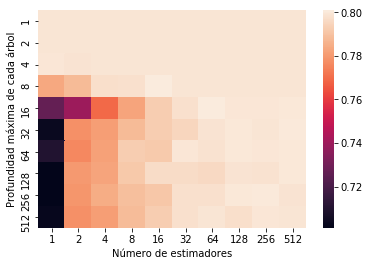

In [8]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(Xtrainst, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>3500)
Ytesttemp=(Ytesttemp>3500)
accuracies=[]
i=0
for depth in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    accuracies.append([])
    for nest in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
        print("depth=", depth, " nest=", nest, end="\r")
        mod=ens.RandomForestClassifier(n_estimators=nest, max_depth=depth)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  xticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set(xlabel='Número de estimadores', ylabel='Profundidad máxima de cada árbol')


 Tuvimos un mal resultado pues separamos los 20% artículos más compartidos, y la precisión máxima fue de 80%. Dado que intentamos predecir el 20% más exitoso, un algoritmo que prediga a todos "no exitoso" obtendría 80% de éxito. Dado que ése fue el éxito máximo, no usaremos esta etiqueta.

### Intento 2.- Popular implica ser del 49% de artículos con mayor numero de veces compatidos en redes 

Por lo anterior, decidimos partir a los artículos entre los que fueron compartidos más de 1500 veces (populares) y los que fueron compartidos menos de 1500 veces (no populares). El resultado fue mucho mejor, logramos ver que la precisión roza el 68%. Dado que (aproximadamente) la mitad de los artículos tienen la variable dependiente con 1 y la otra mitad con 0, un clasificador "bruto" que asigne lo mismo a todo, está topado a un éxito del 50%. Cualquier precisión sobre ésa será de un clasificador mejor al "bruto".

In [9]:
print(sum(Ytrain>=1500)/sum(Ytrain>=0))

0.4936602428278344


In [10]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(Xtrainst, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for depth in [1, 2, 4, 8, 16, 32, 64]:
    accuracies.append([])
    for nest in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
        print("depth=", depth, " nest=", nest, end="\r")
        mod=ens.RandomForestClassifier(n_estimators=nest, max_depth=depth)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1


[Text(33,0.5,'Profundidad máxima de cada árbol'),
 Text(0.5,15,'Número de estimadores')]

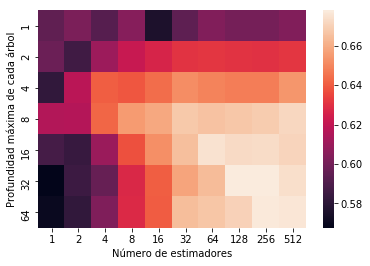

In [11]:
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64],   xticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set(xlabel='Número de estimadores', ylabel='Profundidad máxima de cada árbol')

En el mapa de calor de arriba se sugiere que la mejor precisión se obtiene con una profundida de 16  o 32 nodos, y un número de estimadores o arboles entre 128 y 512. 

Ahora, podremos hacer nuestro método de eliminación recursiva de variables. Lo ideal, sería correr ese programa con el modelo ideal visto arriba. Esto porque finalmente buscaremos las mejores variables para el mejor modelo. Sin embargo, supondremos que la base tiene cierta "monotonicidad". Esto es, que para distintos híperparámetros (peores o mejores), las variables más importantes son las mismas. Por lo tanto, optimizaremos con una combinación no mala como sería depth=1 y n_estimators=1, pero tampoco idea como las primeras mencionadas ya que tardaría bastante. Nos decidimos por depth=4, y número de estimadores=8.

## 3.2 Eliminación recursiva de variables

Usaremos el modelo _baseline_ decidido arriba para ir quitando variables recursivamente. Nuestra función corre el modelo baseline quitando una variable a la vez y devuelve la variable que menos disminuyo el accuracy rate al ser removida. El ciclo programado abajo hace esto recursivamente hasta que quedan cinco variables. Así podemos ver cuál es la máxima precisión limitando cada vez más el número de variables

In [12]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(Xtrainst, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
mod=ens.RandomForestClassifier(n_estimators=8, max_depth=4, random_state=555953)
menos_importantes=[]
precisiones=[]
XTRT=Xtraintemp.copy()
YTRT=Ytraintemp.copy()
XTTT=Xtesttemp.copy()
YTTT=Ytesttemp.copy()
for j in range(len(XTRT.keys())-5):
    mine, maxa=MenosImportante(XTRT, YTRT,XTTT, YTTT , mod)
    menos_importantes.append(mine)
    precisiones.append(maxa)
    aux=XTRT.pop(mine)
    aux=XTTT.pop(mine)
    

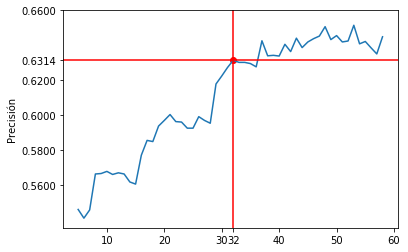

In [13]:
ticks=[]
for j in range(len(Xtraintemp.keys())-5):
    ticks.append(len(Xtraintemp.keys())-1-j)

plt.plot(ticks,precisiones)
plt.ylabel('Precisión')
plt.scatter(ticks[26], precisiones[26], color='red')
plt.xticks([10, 20,ticks[26], 30, 40, 50, 60] )
plt.yticks([0.56, 0.58, 0.6, 0.62, precisiones[26], 0.66])
plt.axvline(x=ticks[26], color='red')
plt.axhline(y=precisiones[26], color='red')

plt.show()


**Hemos elegido quedarnos con las mejores 32 variables**, ya que la pérdida en la que incurrimos por perder el resto (24) es menor al 2.3% en la precisión. Sin embargo, perder cualquiera de estas 32 variables nos llevaría a perder, como mínimo, 3%. Para la operación de quitarlas, vemos que todas las variables (que ya tenemos ordenadas por importancia) antes de la 27 son prescindibles. Por lo tanto las quitaremos

In [14]:
xtrainsel=Xtrainst.copy()
Xteststsel=Xtestst.copy()
for j in range(27):
    aux=xtrainsel.pop(menos_importantes[j])
    aux=Xteststsel.pop(menos_importantes[j])
    

## 3.3 Modelado

Como hicimos antes, una vez más haremos grids de los hiperparámetros posibles, para ver cuál es la mejor elección en cada modelo; e incluso poderlos comparar. Elegimos tres modelos:

* Random forest
* Máquina de soporte vectorial
* K-vecinos más cercanos

Para cada uno elegimos dos parámetros que afinar y graficamos un mapa de calor que representa una malla con todas las combinaciones posibles. 

### Random forest

En este modelo, usaremos una malla donde comparamos el desempeño de sus predicciones para distintas profundidades máximas para cada árbol, y distinto número de estimadores (árboles). Elegiremos la combinación que arroje la mayor precisión.

[Text(33,0.5,'Profundidad máxima de cada árbol'),
 Text(0.5,15,'Número de estimadores')]

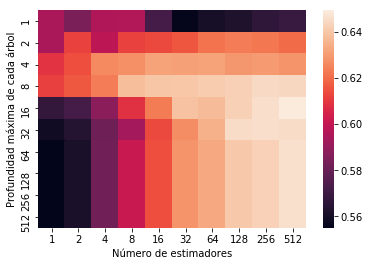

In [15]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for depth in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    accuracies.append([])
    for nest in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
        print("depth=", depth, " nest=", nest, end="\r")
        mod=ens.RandomForestClassifier(n_estimators=nest, max_depth=depth, random_state=555953)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  xticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set(xlabel='Número de estimadores', ylabel='Profundidad máxima de cada árbol')

Vemos que añadir profundidad más allá de 16 no ayuda. Por otro lado, vemos que el mejor número de estimadores es 512. Sugerimos que la mejor combinación es máxima profundidad=16 y máximo número de estimadores=512.

### Máquina de soporte vectorial

Ahora probaremos el desempeño de máquinas de soporte vectorial. En estos, decidimos variar el tipo de Kernel, y el parámetro de penalty del error. 

[Text(33,0.5,'C'), Text(0.5,15,'Kernel')]

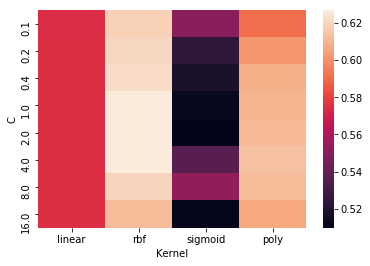

In [23]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for C in [0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0, 16.0]:
    accuracies.append([])
    for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
        print("C=", C, " nest=", kernel, end="\r")
        mod=svm.SVC(C=C, kernel=kernel, random_state=555953)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0, 16.0],  xticklabels=['linear', 'rbf', 'sigmoid', 'poly'])
ax.set(xlabel='Kernel', ylabel='C')

Encontramos que lo mejor parece ser el Kernel  **RBF (Radial Basis Function)** con un parámetro de penalty de error de 2.0

### K vecinos más cercanos

Finalmente intentaremos mejorar el accuracy rate con un modelo de K vecinos más cercanos variando dos hiperparámetros: el número de vecinos (de 1 a 256) y el peso de cada vecino (ponderado por distancia o uniforme).

[Text(33,0.5,'Number of neighbors'), Text(0.5,15,'Weights')]

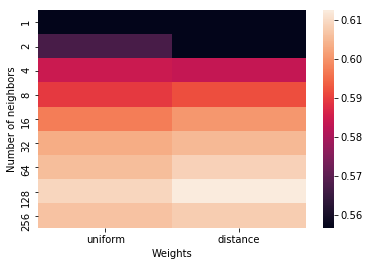

In [22]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for nn in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    accuracies.append([])
    for weight in ['uniform', 'distance']:
        print("n_neighbors=", nn, " weights=", weight, end="\r")
        mod=neigh.KNeighborsClassifier(n_neighbors=nn, weights=weight)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256],  xticklabels=['uniform', 'distance'])
ax.set(xlabel='Weights', ylabel='Number of neighbors')

Vemos que ambos modelos tienen su mejor predicción en 128 vecinos. Sin embargo, es mejor siempre el peso ponderado por distancia al no ponderado, excepto en el caso de los dos vecinos más cercanos. 

**El mejor modelo, con base en las gráficas, parece ser Random Forest con 512 estimadores y profundidad de 16.** 

A continuación observaremos ese modelo a mayor detalle.

## 3.4 Random forest a mayor detalle: Selección de thresholds

Hemos elegido como mejor modelo a RF porque fue el que dió mayor precisión. Ahora lo veremos a mayor detalle. Para empezar, veremos cómo se comporta la curva ROC. Es importante porque nos da información acerca de cómo ir bajando el threshold de "popularidad" aumenta los falsos positivos pero también decrece los falsos negativos. 

In [78]:
Ytrain=(Ytrain>1500)
Ytest=(Ytest>1500)
mod=ens.RandomForestClassifier(n_estimators=512, max_depth=16, random_state=555953)
mod.fit(Xtrainst,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=1,
            oob_score=False, random_state=555953, verbose=0,
            warm_start=False)

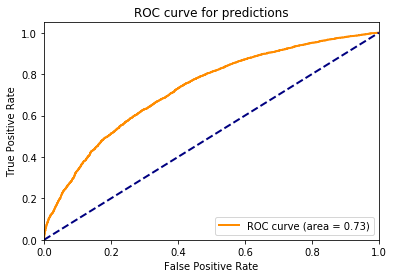

In [79]:
y_scoretup = mod.predict_proba(Xtestst)
y_score=[]
s=0
for ok in y_scoretup:
    y_score.append(ok[1])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Ytest, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Ytest.ravel(), y_score)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predictions')
plt.legend(loc="lower right")
plt.show()

Con base en la curva podemos ver que un FPR de 50% logtamos un TPR cercano a 80%. A continuación damos más información de esta relación.

In [80]:
nextv=0.2
index=0
while nextv<1:
    while tpr[0][index]<nextv:
        index=index+1
    print("Para encontrar el ", round(nextv*100), "% más propenso a ser popular, un ", round(fpr[0][index]*100), "% de los negativos será confundido con popular")
    nextv=nextv+0.2

Para encontrar el  20 % más propenso a ser popular, un  5.0 % de los negativos será confundido con popular
Para encontrar el  40 % más propenso a ser popular, un  13.0 % de los negativos será confundido con popular
Para encontrar el  60 % más propenso a ser popular, un  27.0 % de los negativos será confundido con popular
Para encontrar el  80 % más propenso a ser popular, un  48.0 % de los negativos será confundido con popular


Ahora veremos, para distintos thresholds, qué porcentaje de lo predicho correctamente positivo será negativo; y qué porcentaje de las noticias serían clasificadas positivas

In [105]:
threshs=range(1000)
perc_pos=[]
perc_corr_pos=[]
xaxis=[]
for k in threshs:
    print(k, end="\r")
    k=k/1000
    y_pred_th=[i>k for i in y_score]
    if sum(y_pred_th)>0:
        xaxis.append(k)
        perc_pos.append(sum([i>k for i in y_score])/len(y_score))
        perc_corr_pos.append(precision_score(Ytest.ravel(), y_pred_th))

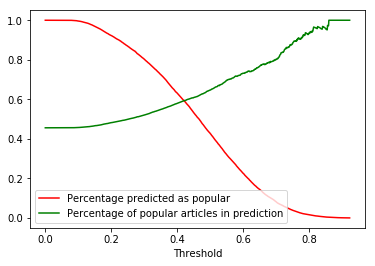

In [110]:
plt.plot(xaxis, perc_pos, color='red')
plt.plot(xaxis, perc_corr_pos, color='green')
plt.legend(['Percentage predicted as popular', 'Percentage of popular articles in prediction'])
plt.xlabel("Threshold")
plt.show()


Con base en la curva anterior, podemos ver que si la empresa quiere una mayor precisión en sus predicciones, puede mover el threshold de decisión para aumentarla. A continuación ejemlos:

In [122]:
nextv=0.1
index=0
while nextv<1 and index<len(xaxis):
    while xaxis[index]<nextv:
        index=index+1
        if index==len(xaxis):
            break
    if index!=len(xaxis):
        print("Con un threshold de ", round(xaxis[index]*100), "%:\nEl ", round(perc_pos[index]*100), "% de los artículos serán clasificados como populares. De esos, el ",round(perc_corr_pos[index]*100),"% lo serán realmente")
    nextv=nextv+0.1

Con un threshold de  10 %:
El  100.0 % de los artículos serán clasificados como populares. De esos, el  46.0 % lo serán realmente
Con un threshold de  20 %:
El  92.0 % de los artículos serán clasificados como populares. De esos, el  48.0 % lo serán realmente
Con un threshold de  30 %:
El  80.0 % de los artículos serán clasificados como populares. De esos, el  52.0 % lo serán realmente
Con un threshold de  40 %:
El  63.0 % de los artículos serán clasificados como populares. De esos, el  58.0 % lo serán realmente
Con un threshold de  50 %:
El  43.0 % de los artículos serán clasificados como populares. De esos, el  65.0 % lo serán realmente
Con un threshold de  60 %:
El  22.0 % de los artículos serán clasificados como populares. De esos, el  73.0 % lo serán realmente
Con un threshold de  70 %:
El  8.0 % de los artículos serán clasificados como populares. De esos, el  80.0 % lo serán realmente
Con un threshold de  80 %:
El  2.0 % de los artículos serán clasificados como populares. De esos,

Nosotros recomendaríamos un threshold de 60% o 50% dependiendo de las prioridades de la empresa. 

# 4 Utilización de la información

Hemos elegido el modelo ganador y otorgado el comportamiento de las predicciones para distintos thresholds. Sin embargo, queda la pregunta: ¿Cómo se usará el modelo para mejorar a la empresa? De entrada, saber la popularidad de una noticia de antemano es positivo. Así la empresa puede saber en qué invertir sus recursos para publicidad, por ejemplo. Sin embargo, buscamos utilizar este modelo para saber qué será lo mejor para cambiar las noticias no populares.

Hicimos una función que encuentra cuál métrica, siendo aumentada en (1/2) desviación estándar, ofrece mejor aumento en popularidad. Cada vez que se escribiera una noticia, se podrían ingresar sus parámetros en nuestro método $MejorarNoticia$ y se obtendrá la mejor variable para aumentar su probabilidad de popularidad. Posteriormente, probamos esto para 200 noticias al azar, para ver si hay parámetros que mejoren a todas las noticias de manera general. Si es el caso, esto daría ideas para implementar políticas dentro de la empresa.

In [179]:
triples=[]
for s in range(200):
    print(s, "/",200, end="\r" )
    triples.append(MejorarNoticia(pd.DataFrame(Xtestst.ix[s].values.reshape(1,-1), columns=Xtestst.keys()), mod))

In [194]:
pd.DataFrame(triples, columns=["Variable", "Cambio", "Signo"])[['Variable','Signo', 'Cambio']].groupby(["Variable", "Signo"]).agg(['mean','count'])

Cambio      
                                       mean count
Variable                    Signo                
 LDA_03                     -1     0.023126     1
 average_token_length       -1     0.055865     2
                             1     0.015868     1
 global_subjectivity        -1     0.015094     1
                             1     0.033943     3
 kw_avg_avg                  1     0.086388    47
 kw_avg_max                  1     0.016062     1
 kw_avg_min                  1     0.042614     6
 kw_max_avg                 -1     0.038357     1
                             1     0.090051    21
 kw_max_min                 -1     0.030501     1
                             1     0.033259     3
 kw_min_avg                  1     0.062199    12
 kw_min_max                  1     0.020731     1
 min_positive_polarity      -1     0.049449     1
 n_non_stop_unique_tokens   -1     0.060197     8
                             1     0.103452     1
 n_tokens_title              1     0.023750     1
 n_unique_tokens            -1     0.054244     8
 num_hrefs                   1     0.013541     2
 num_imgs                    1     0.038695     6
 num_self_hrefs              1     0.012703     1
 self_reference_avg_sharess  1     0.070439    21
 self_reference_max_shares   1     0.030542     4
 self_reference_min_shares   1     0.077737    42
 timedelta                  -1     0.054966     1
                             1     0.075641     3

La tabla anterior muestra cómo se distribuyen las mejores variables para aumentar popularidad. La primera columna denota qué variable se trata. La segunda denota si aumentar la probabilidad se logra aumentándola (1) o reduciéndola (-1) en media desviación estándar. Finalmente, aparece en promedio en cuánto aumentaría la popularidad de forma hipotética en promedio, y el número de artículos cuya popularidad aumenta al máximo al aumentar esa variable. Con base en la tabla, podemos inferir que lo ideal para mejorar un artículo es que el promedio de veces compartidas de las _keywords_ de un artículo (kw_avg_avg) sean más alto para 47 casos de 200. También ayuda que el mínimo de los artículos referenciados (self_reference_min_shares) sea más alto para 42 artículos.  

Lo anterior, puede dar cuenta de qué políticas puede implementar la empresa para construir sus artículos de tal forma que sean más veces compartidos en medios (populares).

# 5 Conclusión

Nosotros hemos visto que un modelo de Random forest con bastantes estimadores y algo de profundidad puede ser un buen predictor para la popularidad, medida como el número de veces que se comparte un artículo. Queda como trabajo futuro:

* Predecir artículos muy populares y muy impopulares
* Predecir la cantidad de veces que se comparte un artículo

El modelo que hicimos es muy versátil. Las prioridades de la empresa podrán definir cuál será el mejor threshold. Por ejemplo, si es menos costoso que un articulo sea pronosticado como no popular y en realidad sí lo sea (un falso positivo), la empresa puede poner el threshold más bajo. En sentido opuesto, si prefiere sólo predicciones seguras, lo puede poner muy alto. Aprendimos que hay variables que son la mejor variable (entre las 32 que usamos al final) para mejorar de forma muy común. Las recomendaciones que haríamos a la empresa con base en lo visto sería:
* Predcir la popularidad de los artículos. Con base en la probabilidad, otorgar más o menos publicidad a cada uno. 
* Dar prioridad a mejorar las métricas que vimos que son más importantes. 

# Referencias

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

Sasa Petrovic, Miles Osborne, and Victor Lavrenko. RT to Win! Predicting Message
Propagation in Twitter. In Fifth International AAAI Conference on Weblogs and Social Media (ICWSM), pages 586–589, 2011.

Elena Hensinger, Ilias Flaounas, and Nello Cristianini. Modelling and predicting
news popularity. Pattern Analysis and Applications, 16(4):623–635, 2013